# Проект: классификация

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

plt.rcParams['figure.figsize']=18,10

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [77]:
df = pd.read_csv(r'data\bank_fin.zip', sep = ';')
print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


* Данные о клиентах банка:  
**age** (возраст);  
**job** (сфера занятости);  
**marital** (семейное положение);  
**education** (уровень образования);  
**default** (имеется ли просроченный кредит);  
**housing** (имеется ли кредит на жильё);  
**loan** (имеется ли кредит на личные нужды);  
**balance** (баланс).  

* Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:  
**contact** (тип контакта с клиентом);  
**month** (месяц, в котором был последний контакт);  
**day** (день, в который был последний контакт);  
**duration** (продолжительность контакта в секундах).  

* Прочие признаки:  
**campaign** (количество контактов с этим клиентом в течение текущей кампании);  
**pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);  
**previous** (количество контактов до текущей кампании)  
**poutcome** (результат прошлой маркетинговой кампании).  
И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.  

In [117]:
# Определим целевую метрику
TARGET = 'deposit'

In [78]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [79]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,11162.0,NaN,NaN,NaN,41.231948,11.913369,18.0,32.0,39.0,49.0,95.0
job,11162,12,management,2566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,11162,3,married,6351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,11162,4,secondary,5476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,11162,2,no,10994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,11137,3802,0 $,774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,11162,2,no,5881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,11162,2,no,9702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,11162,3,cellular,8042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,11162.0,NaN,NaN,NaN,15.658036,8.42074,1.0,8.0,15.0,22.0,31.0


### Задание 2

In [80]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [81]:
def balance_formatter(text:str):
    """Функция для форматирования признака баланкса клиента

    Args:
        text (str): входное значение признак

    Returns:
        str: отформатерованное значение признака
    """
    text = text.strip()
    text = text.replace('$','')
    text = text.replace(' ','')
    text = text.replace(',','.')
    return text

In [82]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: balance_formatter(x) if type(x)!=float else x)

df['balance'] = df['balance'].astype('float')

In [83]:
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 4

In [84]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [85]:
df['balance'].mean()

1526.9360329690019

### Задание 5

In [86]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x) # Преобразование работы
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x) # Преобразование образования

In [87]:
round(df[(df['job']==df['job'].mode()[0])&(df['education']==df['education'].mode()[0])]['balance'].mean(), 3)

1598.883

### Задание 6

In [88]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """Функция для очитки данных от выброса по Тьюки.
    Делит данные на очищенные и отброшенные. Возвращает два датафрейма.
    Сначала отброшенные. потом очищенные.

    Args:
        data (pd.DataFrame): исходный DataFrame для очистки
        feature (string): признак DataFrame, по которому требуется очистка
        left (float, optional): доверительный интервал слева. Defaults to 1.5.
        right (float, optional): доверительный интервал справа. Defaults to 1.5.
        log_scale (bool, optional): флажок для перевода в логарифмическое представление данных. Defaults to False.

    Returns:
        pd.DataFrame, pd.DataFrame: отброшенные данные и очищенные данные соответственно
    """
    
    if log_scale:
        x = np.log(data[feature])
        
    else:
        x= data[feature]
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned, lower_bound, upper_bound

<AxesSubplot:xlabel='balance'>

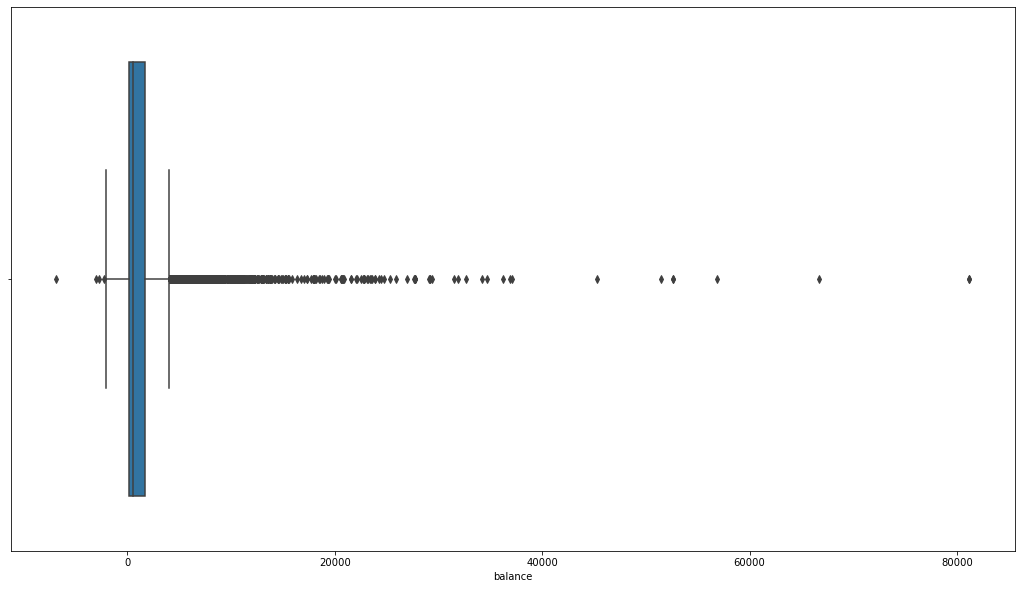

In [89]:
sns.boxplot(df['balance'])

In [90]:
# удалите все выбросы для признака balance
_, df, lower_bound, upper_bound  = outliers_iqr_mod(df, 'balance')

print(lower_bound, upper_bound)

-2241.0 4063.0


In [91]:
print(df.shape, _.shape)
del _

(10104, 17) (1057, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

(<AxesSubplot:xlabel='deposit', ylabel='Count'>,
 no     5423
 yes    4681
 Name: deposit, dtype: int64)

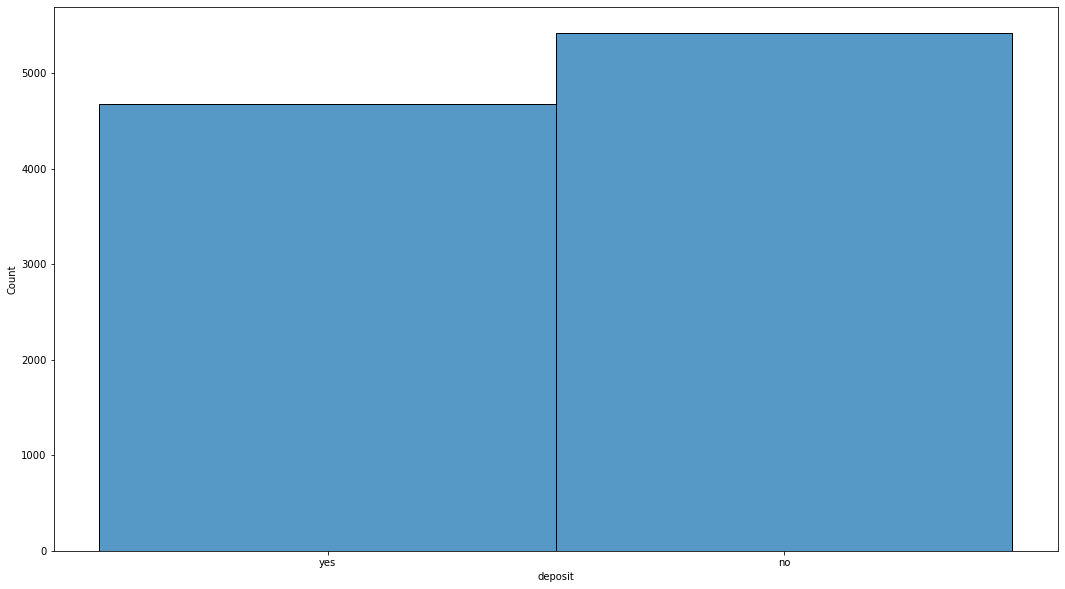

In [92]:
# Сколько клиентов открыли депозит?

sns.histplot(df['deposit']), df['deposit'].value_counts()

#### Наблюдения:  
Депозит открыло немногим менее половины клиентов (4861 человек).

### Задание 2

In [93]:
num_cols = list(df.loc[:, df.dtypes != object].columns)
num_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

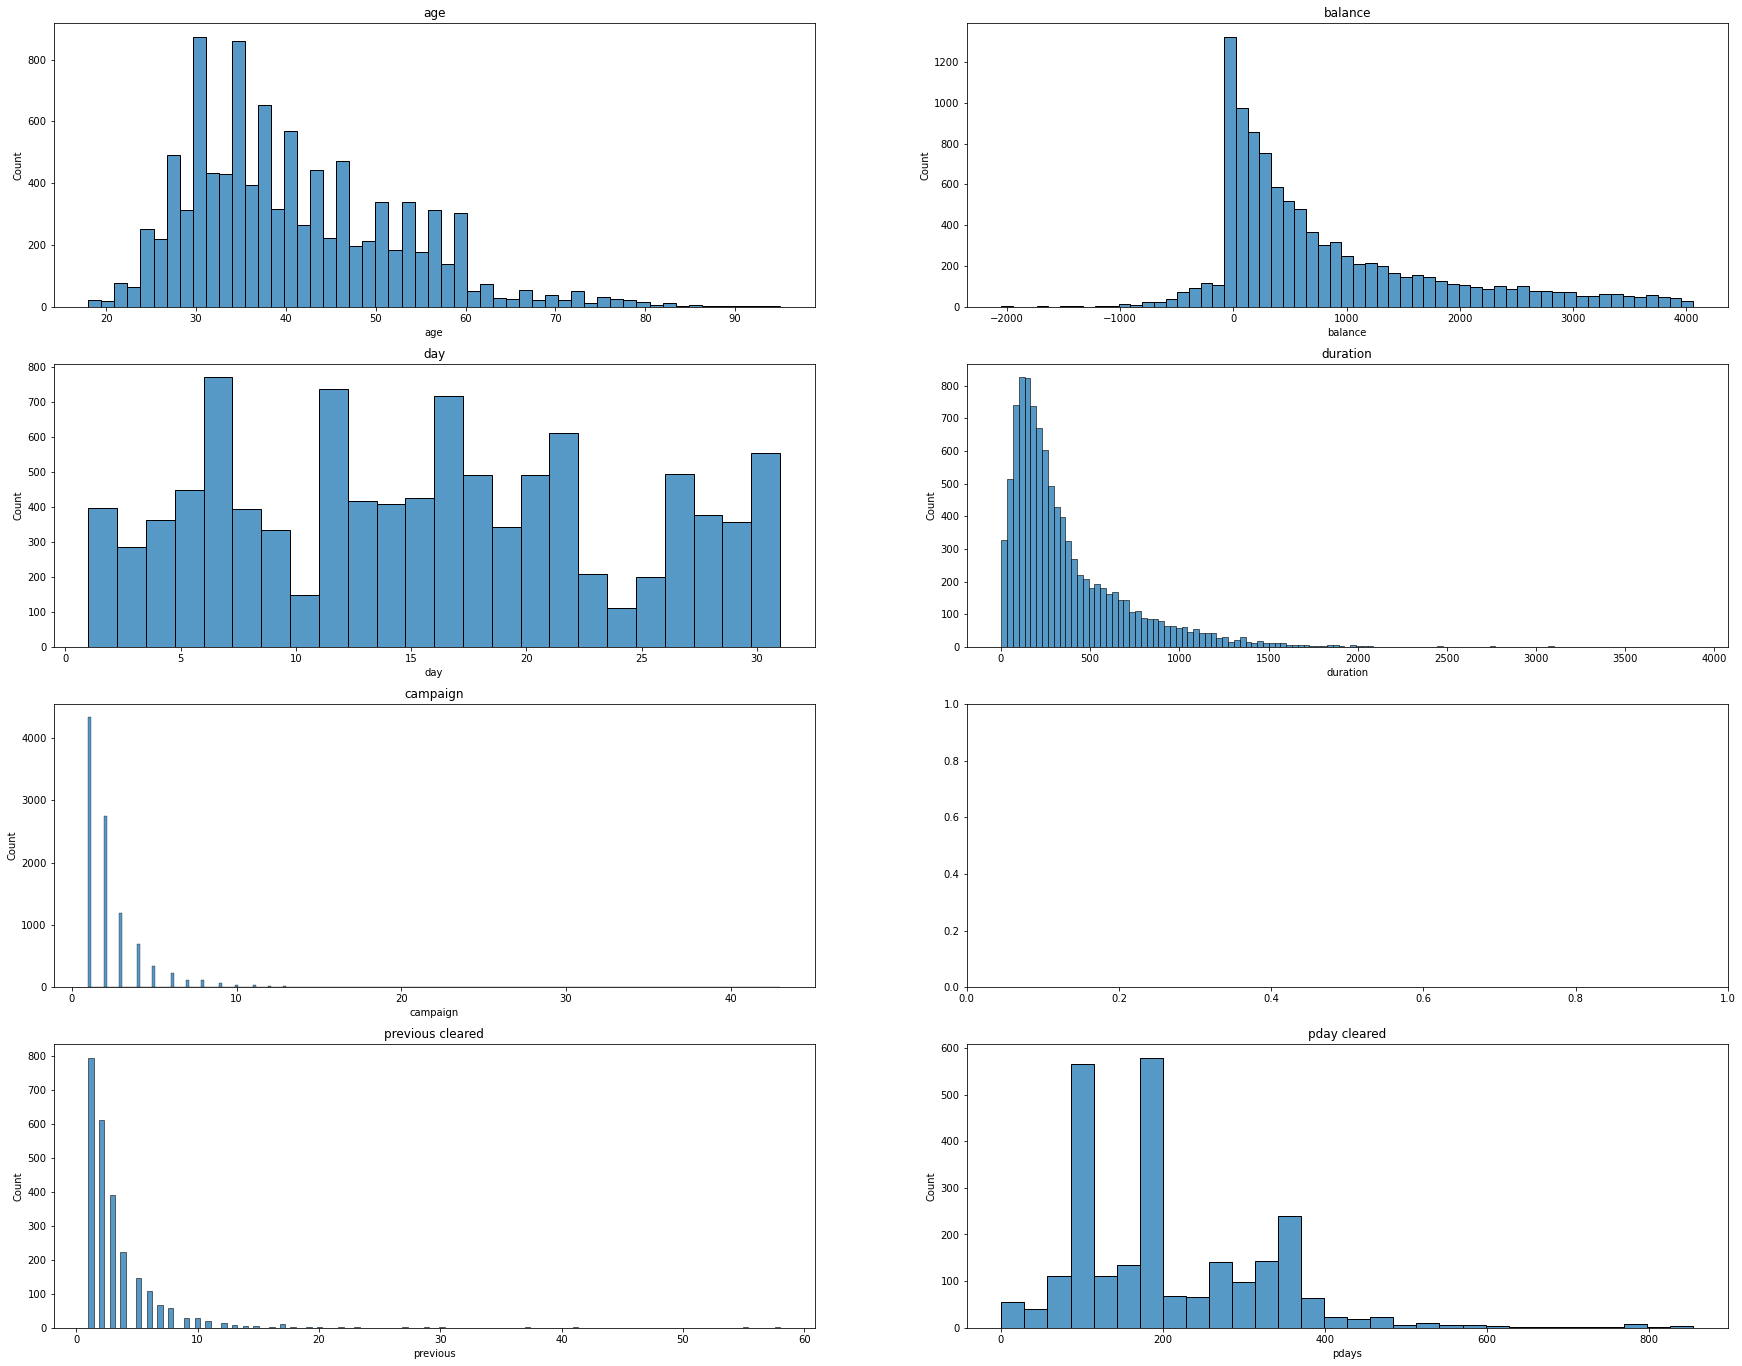

In [94]:
# Изучим количественные признаки в данных на, проиллюстрируем результат
from cProfile import label


fig, axes = plt.subplots(4,2, figsize=(30,24),edgecolor='white')

axes = axes.reshape(8,)
for ax, col in zip(axes[:-2], num_cols[:-2]):
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)
    
# Данные для признаков previous и pdays необходимо дополнительно итерпретировать и отбросить людей, 
# которые не участовали в предыдущей кампании:
sns.histplot(df[df['previous']>=1]['previous'], ax=axes[-2]).set_title('previous cleared')
sns.histplot(df[df['pdays']>0]['pdays'], ax=axes[-1]).set_title('pday cleared')

fig.show()

In [95]:
df['pdays'].value_counts()[1:5]

92     88
182    77
181    75
91     74
Name: pdays, dtype: int64

#### Наблюденя:
* Возраст людей в представленном сете имеет нормальное распределение со смещением, виден пик в районе 32-35 лет, что весьма понятно, так как это самый активный финансовый возраст.
* Распределение балансов имеет логнормальную форму, имеющее небольшое искажение слева.
* Распределение дней контакта с людьми имеет равномерный характер.
* Продолжительность контакта, количество контактов и результаты прошлой кампании имеет логнормальное распределение.
* Количество дней с предыдущей компании не имеет ярковыраженного распределения, но имеет два пика в районе 90 и 180 (то есть через 3 месяца и через 6 месяц)

In [96]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10104.0,40.895487,11.735511,18.0,32.0,38.0,48.00,95.0
balance,10104.0,807.331354,993.673452,-2049.0,95.0,444.5,1224.75,4062.0
day,10104.0,15.590657,8.441852,1.0,8.0,15.0,22.00,31.0
duration,10104.0,368.777712,346.650712,2.0,137.0,252.0,490.00,3881.0
campaign,10104.0,2.516924,2.707180,1.0,1.0,2.0,3.00,43.0
pdays,10104.0,51.307700,109.643031,-1.0,-1.0,-1.0,2.00,854.0
previous,10104.0,0.816112,2.243875,0.0,0.0,0.0,1.00,58.0


### Задание 3

#### Описание:
Видно, что маркетинговая кампания проводилась 12 месяцев. Всего клиенты представляют 11 сфер деятельности.

In [105]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
cat_cols = list(df.nunique()[df.nunique()<12].index)
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'deposit']

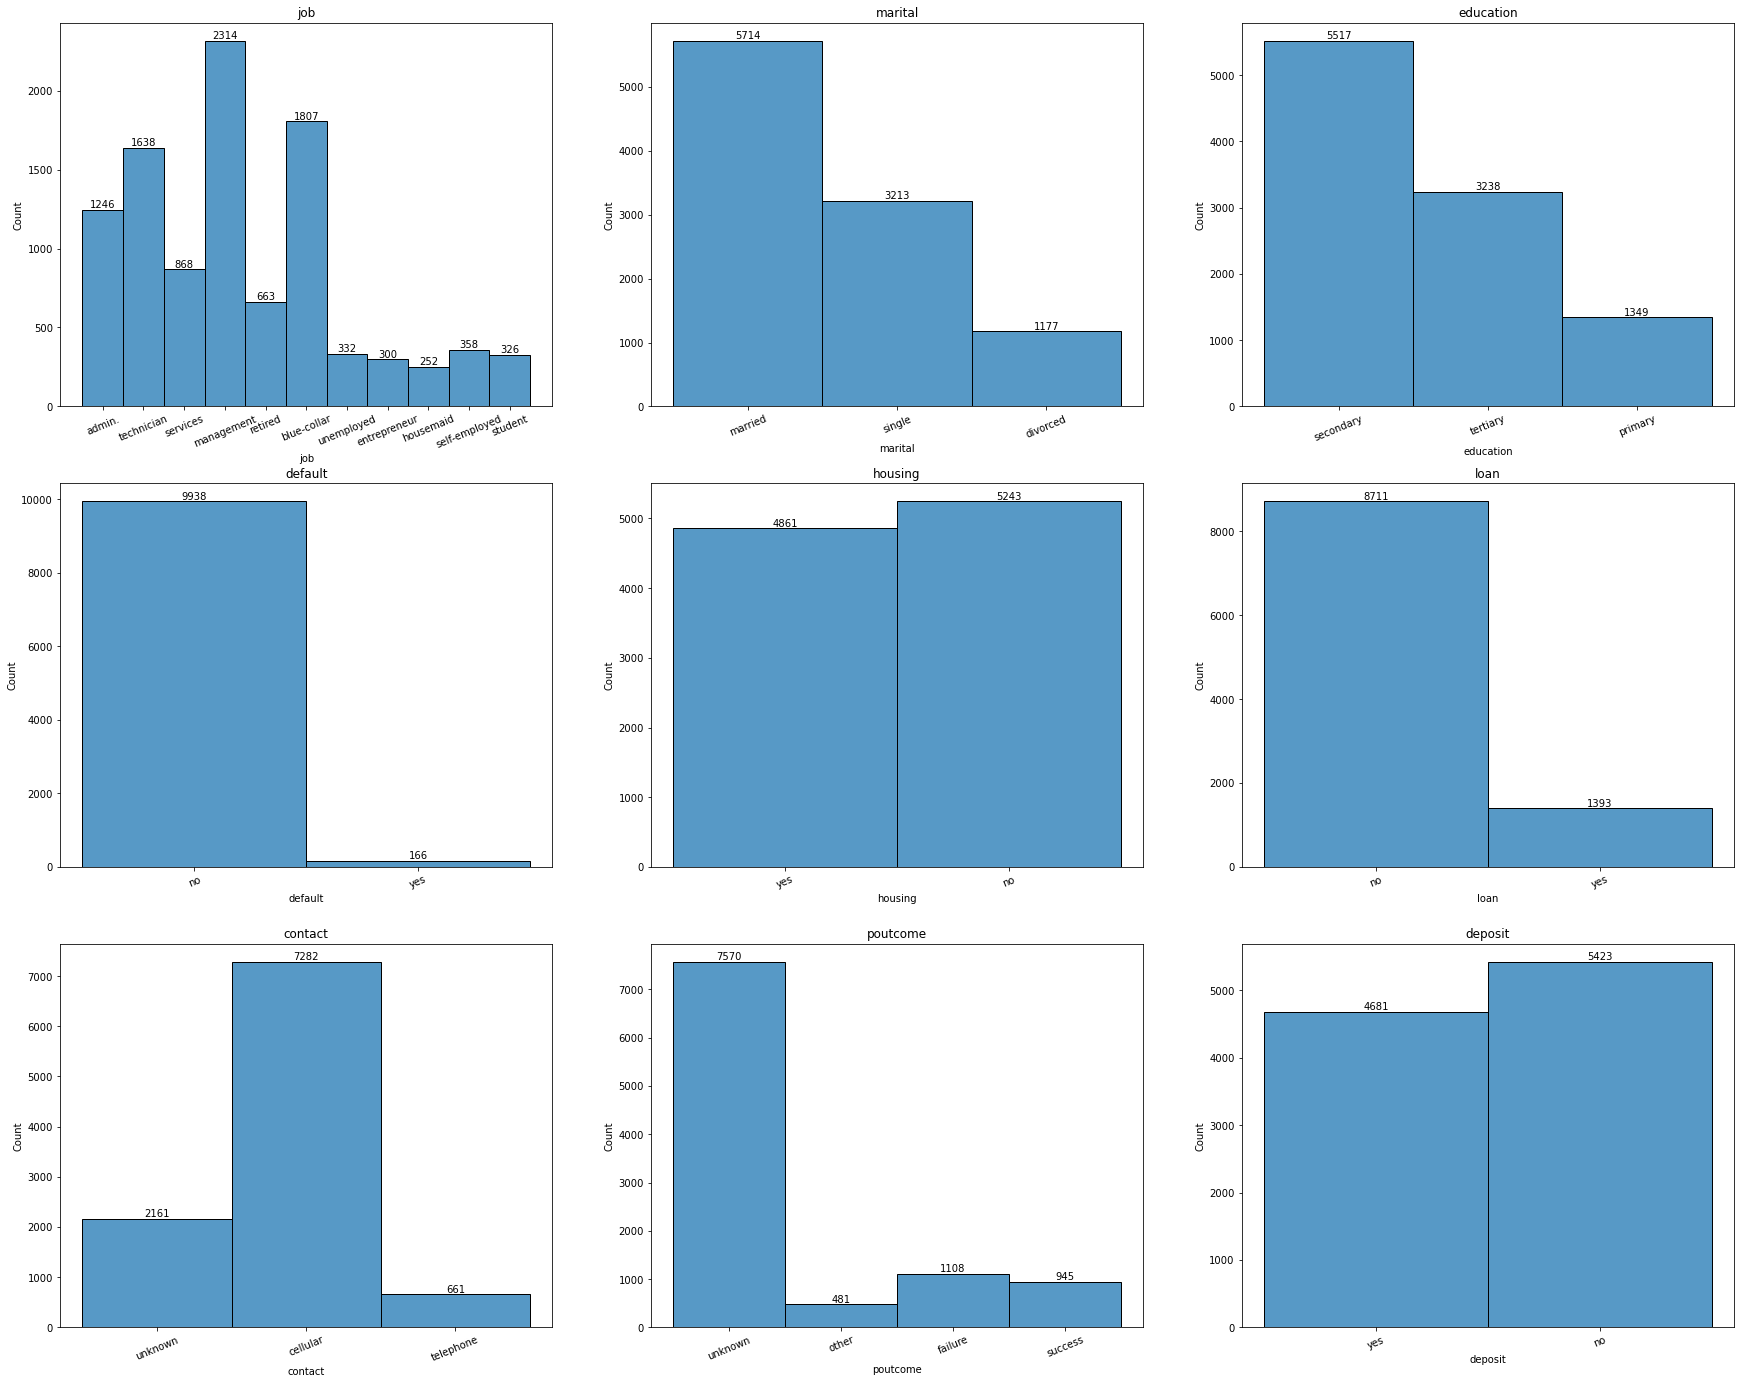

In [98]:
fig, axes = plt.subplots(len(cat_cols)//3,3, figsize=(30,24),edgecolor='white')

axes = axes.reshape(len(cat_cols),)
for ax, col in zip(axes, cat_cols):
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', labelrotation=22.5)
    for container in ax.containers:
        ax.bar_label(container)
    
fig.show()

#### Наблюдения:  
* Распределения видов деятельности при ранжировании по количеству можно назвать логнормальным. Преобладают менеджеры, а самой непопулярной деятельностью среди клиентов банка являют домработницы.
* Семейное положение большинства клиентов - в браке, а меньшинство - в разводе.
* Большинство клиентов имеет среднее образование.
* В состоянии дефолта по долгам находится меньшенство людей (166).
* Немногим меньше половины (4861) имеет кредит на дом. 
___
**Эта цифра совпадает с наличием депозита и по всей видимости она может каким-то образом коррелировать с количеством людей имеющим депозит.**  
___
* Большинство людей не имеет потребительский кредит (8711).
* Тип контакта для большинства людей определен как контакт через звонок на сотовый телефон (7282), меньшинству звонили на стационарный (661), для остальных людей тип контакта не определен.
* Метрика poutcome показывает результат прошлой кампании и самый большой класс здесь - неопределенность результата (7570), вторая категория по количество это отказ (1108), а успешна кампания были в 945 случаях. Категория другое является меньшенством с показателем в 481
* Целевая метрика открытия депозита представляет собой сбалансированный класс. Отказ - 5423, успех - 4681.

### Задание 4

In [108]:
# Зададим список признаком прошлой кампании
last_camp_cols = list(df.columns[-5:-1])
last_camp_cols

['campaign', 'pdays', 'previous', 'poutcome']

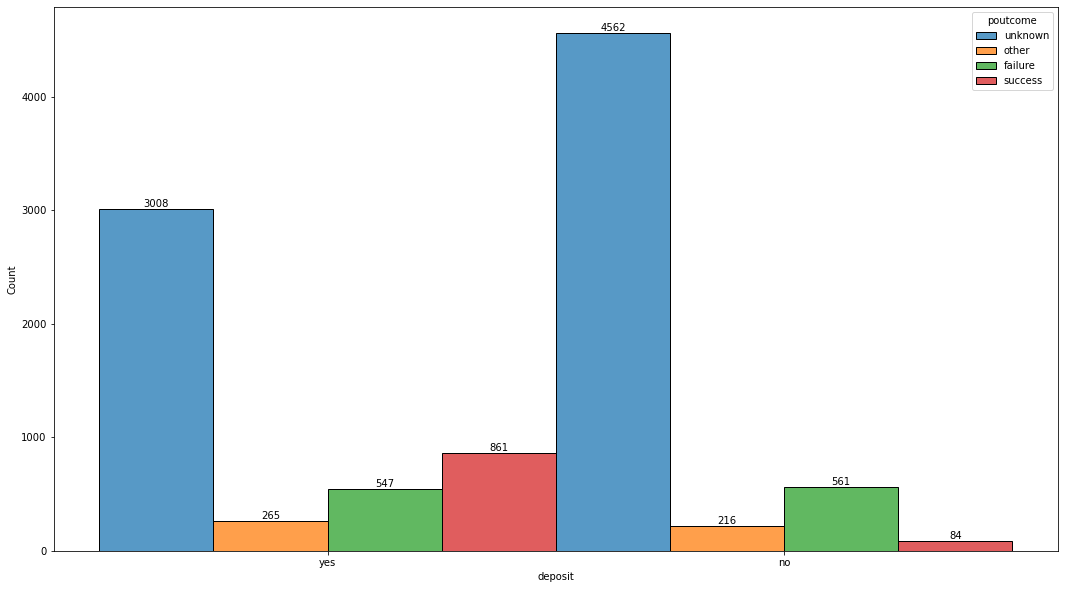

In [118]:
# Посмотрим на влияние прошлой кампании на целевую метрику

fig = sns.histplot(df,x=TARGET, hue='poutcome',multiple="dodge")
for container in fig.containers:
        fig.bar_label(container)

#### Наблюдения
* Из гистограммы видно, что люди, с которыми сзаимодействовали в прошлой кампании вне зависимости от результата более склонны к открытию депозита, чем люди, которые не попали в прошлую кампанию.
* Превалирующий класс из прошлой кампании это люди, которые также открыли кредит в результате проведения кампании до этого.

### Задание 5

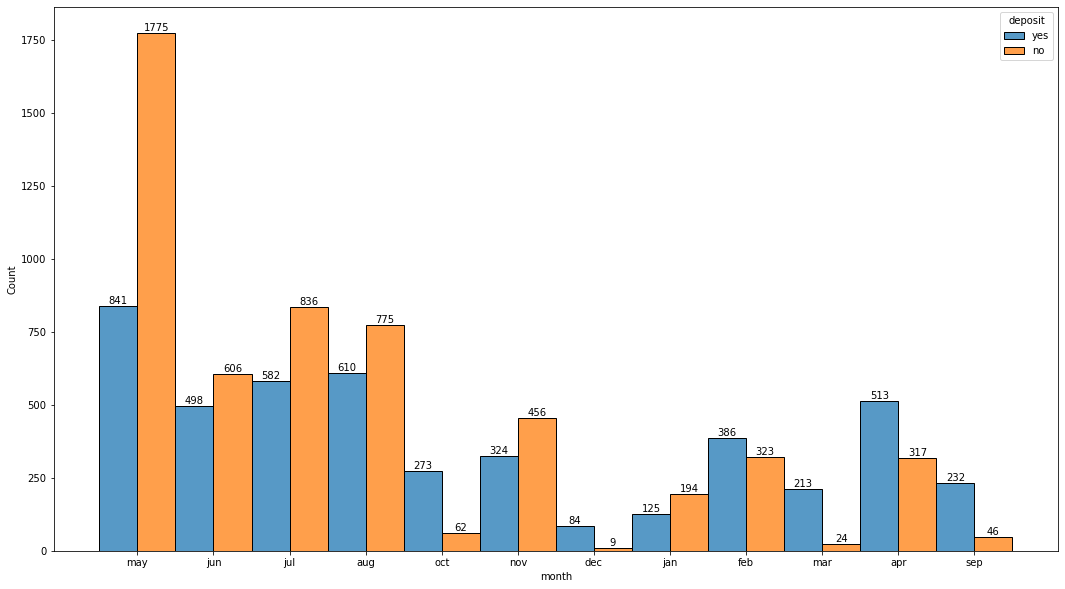

In [123]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

fig = sns.histplot(df,x='month', hue=TARGET,multiple="dodge")
for container in fig.containers:
        fig.bar_label(container)

#### Наблюдения:
* Самым успешным месяцем по открытию депозитов стал май, при этом в этом месяце совершено самое большое количество контактов. Логично, что раз наибольшее количество контактов было в этом месяце, наибольшее количество успехов связано с ним. Можно предположить, что май - начало или конец кампании, так как такой всплеск обычно наблюдается в начале или в конце.
* Видно, что самые удачные месяцы были октябрь, декабрь, март и сентябрь, где количество успехов значительно больше количества неудач по открытию депозитов.
* Самые неуспешные в плане соотношения успехов к неудачам были май, июнь, июль, август и ноябрь. Предположительно это связано с подготовкой к новогодним праздникам в ноябре и подготовке и поездках в отпуска для теплых месяцов.


___  
**Успешность предложения имеет ярковыраженную сезонность.**

### Задание 6

In [127]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_group(val):
    """Метод разбивки на возрастные группы

    Args:
        val (int): возраст

    Returns:
        str: возрастная группа
    """
    
    if val <= 30:
        return '<30'
    
    elif val <= 40:
        return '30-40'
    
    elif val <= 50:
        return '40-50'
    
    elif val <= 60:
        return '50-60'
    
    elif val > 60:
        return '60+'

In [128]:
df['age_group'] = df['age'].apply(age_group) # Обработаем возраст и разобьем на группы

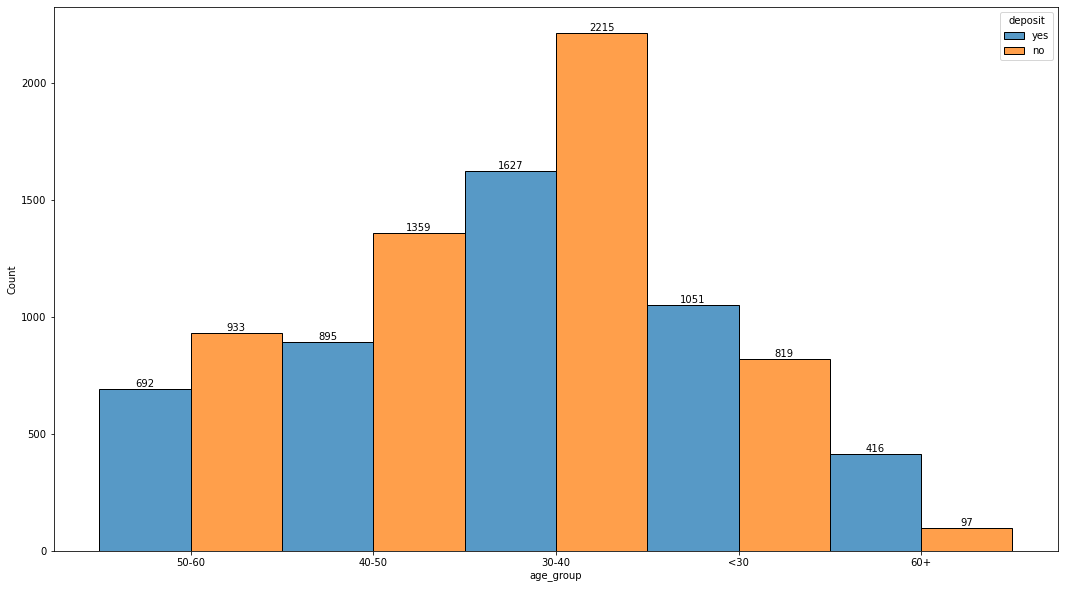

In [129]:
fig = sns.histplot(df,x='age_group', hue=TARGET,multiple="dodge")
for container in fig.containers:
        fig.bar_label(container)

#### Наблюдения:
* Видно, что две возрастные группы, где открытие депозита превалирует это "<30" и "60+".
* Также отмечается, что во всех остальных группах люди более склонны депозит не открывать.

___  
**Можно предположить, что депозит является нишевым продуктом, либо рекламная кампания была нацелена на определенные возрастные группы, чем можно объяснить такую картину.**

### Задание 7

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

In [140]:
cols_to_vis = ['marital' ,'education', 'job'] # Зададим признаки для рассмотрения

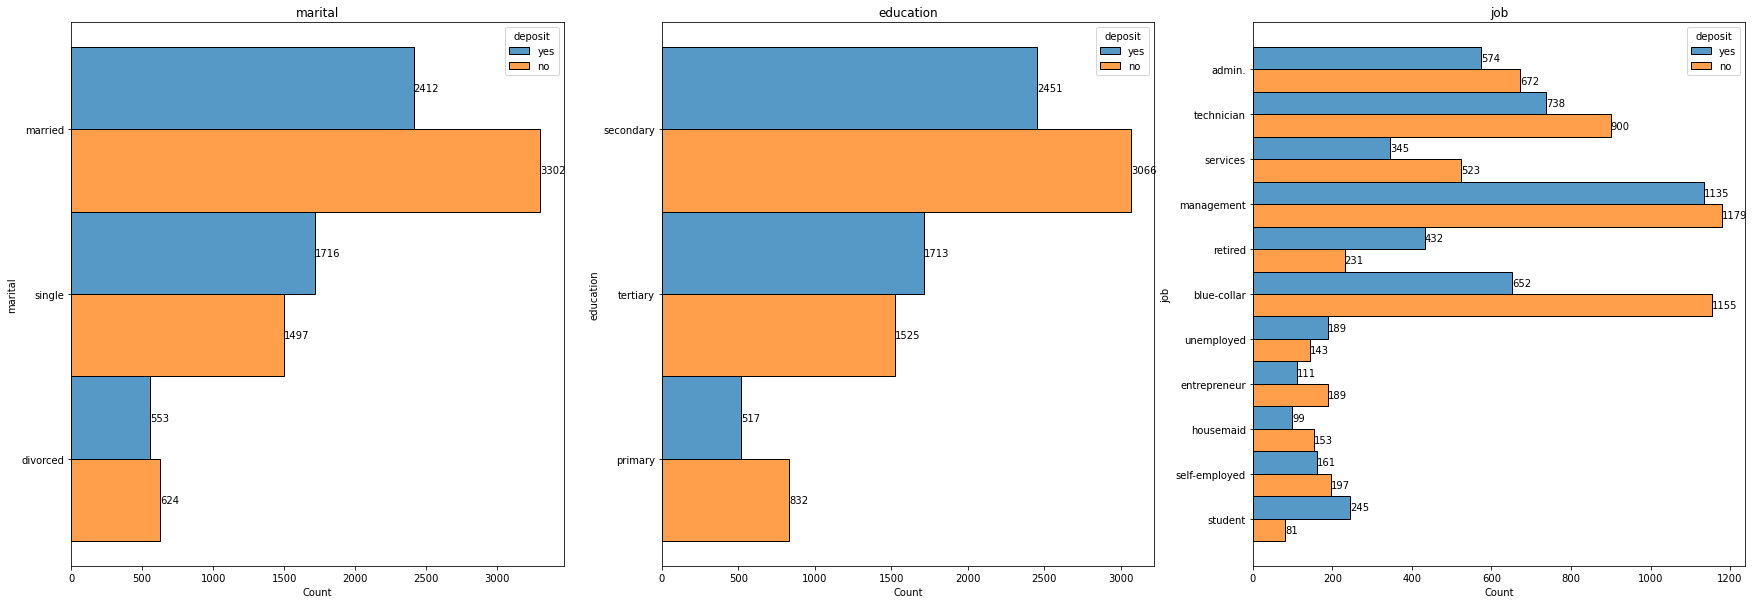

In [154]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, axes = plt.subplots(1,len(cols_to_vis), figsize=(30,10),edgecolor='white')

for ax, col in zip(axes, cols_to_vis):
    sns.histplot(df,y=col, hue=TARGET,multiple="dodge", ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x')
    for container in ax.containers:
        ax.bar_label(container)
    
fig.show()

#### Наблюдения:  

* Среди одиноких людей больше тех, кто открыл депозит. А худший процент успеха в категории состоящих в браке.
* Наиболее успешен депозит у людей с высшим образованием, а худший процент у людей с образованием начального уровня.
* Наибольшую популярность депозит имеет у студентов, а наименьшую у "синих воротничков".

### Задание 8

In [174]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны

df.pivot_table(values='age',index=['education','marital'], columns='deposit', aggfunc='count')

deposit               no   yes
education marital             
primary   divorced    91    96
          married    641   339
          single     100    82
secondary divorced   370   283
          married   1830  1289
          single     866   879
tertiary  divorced   163   174
          married    831   784
          single     531   755

<AxesSubplot:xlabel='deposit', ylabel='education-marital'>

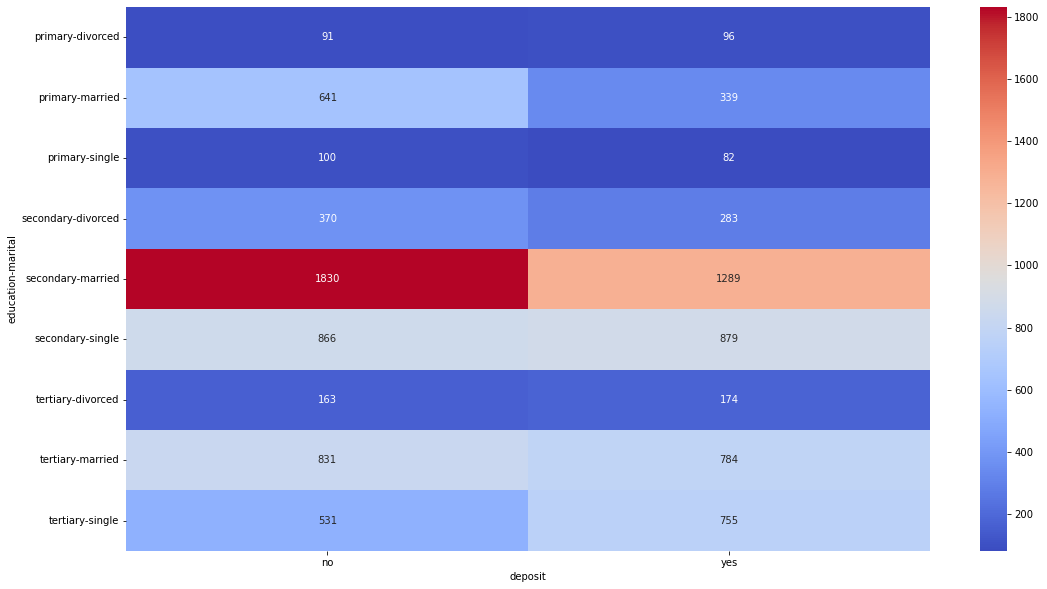

In [176]:
sns.heatmap(df.pivot_table(values='age',index=['education','marital'], columns='deposit', aggfunc='count'), annot=True, fmt='d', cmap='coolwarm')

#### Наблюдения:  

* Наиболее многочисленные категории для открывших и не открывших депозит - люди со средним образованием в браке.

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задание 2

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 3

In [ ]:
# создайте дамми-переменные

### Задание 4

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задание 5

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 6

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 7

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задание 2

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 3

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задание 2

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание3

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 4

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna